../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_flowaug-gen
Predicting 31 labels: [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63]
(84, 31)
Mean dice: 0.774334524516129


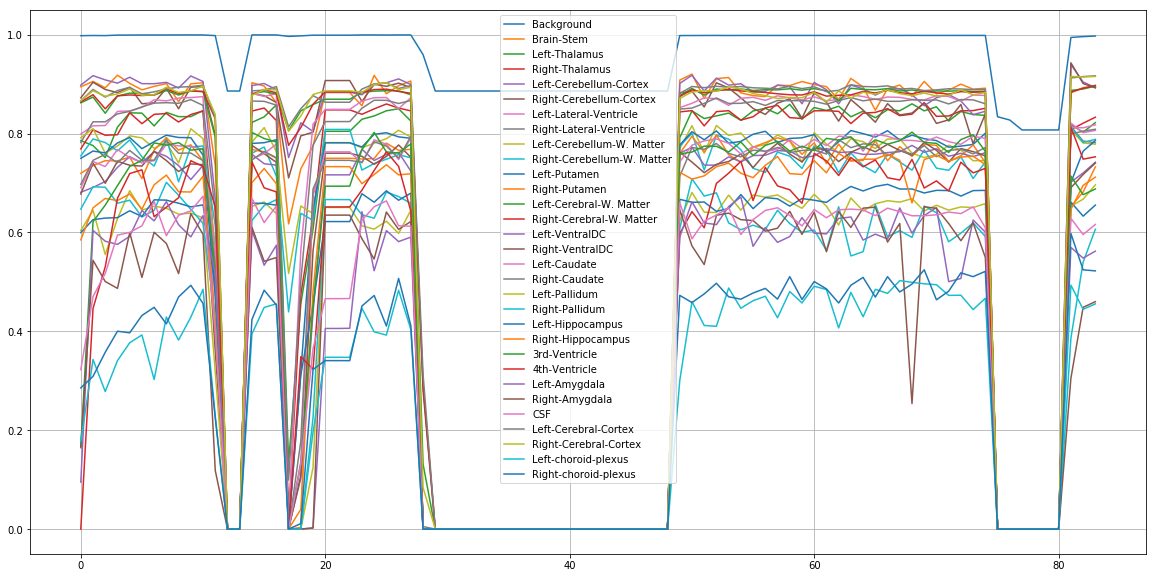

FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_sasaug100-vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000
Predicting 31 labels: [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63]


AssertionError: 

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pylab as plt
%matplotlib inline
import os
import numpy as np
import json
import cv2
import PIL
import sys
import json
import re
import ast

sys.path.append('../')
from cnn_utils import file_utils, vis_utils

import plot_utils


include_splits = [0, 1, 2]

include_strs = ['FewShotSeg', '32-32', 'subj-OASIS', 'unnorm']
exclude_strs = ['--1', 'randmult0.4', 'halfres', 'atlas-l', 'all-l', 'randoffset']
exp_root = './experiments'

target_metric = 'new_top1acc'
target_metric = 'dice'

#include_exps = [exp for exp in os.listdir(exp_root) if np.all([s in exp for s in include_strs]) and not np.any([s in exp for s in exclude_strs])]
include_exps = [
    'FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_augflow-amp200_blur12_randmult0.5_flowaug-gen',
    'FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_sasaug100-vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000',
    'FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper_colorunet-colorregwt1-e1020'
]
n_exps = len(include_exps)

completed_exps = []
splits = [None] * n_exps
dice_per_labels = []


# get label names
label_names_file = '/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph-sandbox/voxelmorph/jupyter/label_names.txt'
with open(label_names_file, 'r') as f:
    label_names = f.readlines()
label_name_mapping = [f.strip() for f in label_names]

import ast

for ei, exp in enumerate(include_exps):
    # read training log to get test accuracy
    exp_log = os.path.join(exp_root, exp, 'experiment.log')
    with open(exp_log, 'r') as ef:
        train_log = ef.readlines()
    
    if len(train_log) <= 10:
        print('Skipping {}, empty log {}'.format(exp, exp_log))
        continue

    labels = [re.search('(?<=Dice per label: \[)[0-9.\, ]*(?=\])', l) for l in train_log]
    pred_labels = [[int(l) for l in ls.group(0).split(', ')] for ls in labels if ls is not None]
    if len(pred_labels) == 0:
        print('Skipping {}, empty log {}'.format(exp, exp_log))
        continue
    print(exp)
    completed_exps.append(exp)
    
    pred_labels = pred_labels[0]
    n_pred_labels = len(pred_labels)
    print('Predicting {} labels: {}'.format(n_pred_labels, pred_labels))
    
    
    dice_start_idxs = [i for i, d in enumerate(labels) if d is not None]
    # need to join consecutive lines since dice scores get written to multiple lines
    dice_lines = [' '.join(train_log[idx:idx + 10]) for idx in dice_start_idxs]
    dice_per_label = [re.search('(?<=\]\, \[)[0-9. e\-\+\\n]*', l) for l in dice_lines]
    dice_per_label = [ds.group(0) for ds in dice_per_label if ds is not None]
    
    dice_per_label = [[float(d) for d in ds.split()] for ds in dice_per_label]
    assert np.all([len(d) == n_pred_labels for d in dice_per_label])
    dice_per_label = np.asarray(dice_per_label)
    print(dice_per_label.shape)
    dice_per_labels.append(dice_per_label)
    data_params_file = os.path.join(exp_root, exp, 'data_params.json')
    with open(data_params_file, 'r') as f:
        data_params = json.load(f)
    
    print('Mean dice: {}'.format(np.max(np.mean(dice_per_label[1:], axis=-1))))
    splits[ei] = data_params['split_id']

    taxis = np.linspace(0, dice_per_label.shape[0], dice_per_label.shape[0], endpoint=False, dtype=int)
    plt.figure(figsize=(20,10))
    plt.plot(taxis, dice_per_label)
    plt.legend([label_name_mapping[pl] for pl in pred_labels])
    plt.grid()
    plt.show()
    


In [20]:
print(len(dice_per_labels))
sas_files = [os.path.join('experiments', f) for f in os.listdir('./experiments') \
             if '_SAS.txt' in f and 'CStoUMS_xy_iter' in f]
print(sas_files)

for sf in sas_files:
    model_name = os.path.splitext(os.path.basename(sf))[0]
    with open(sf,'r') as f:
        dice = f.readlines()
    
    dice_scores = [float(d) for d in dice[0].split(',')]
    print(dice_scores)
    completed_exps.append(model_name)
    dice_per_labels.append(np.tile(np.reshape(dice_scores, (1, len(dice_scores))), (50, 1)))
print(len(dice_per_labels))
print(len(completed_exps))

5
['experiments/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter2000_SAS.txt', 'experiments/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter4000_SAS.txt', 'experiments/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter10000_SAS.txt', 'experiments/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter12000_SAS.txt', 'experiments/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter20000_SAS.txt', 'experiments/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000_SAS.txt']
[0.9899312388896943, 0.9297481143474579, 0.8521795248985291, 0.8599197506904602, 0.8766033291816712, 0.8836177182197571, 0.8310119783878327, 0.820928475856781, 0.7700490379333496, 0.7671001785993576, 0.80818124294281, 0.8015010476112365, 0.8129580736160278, 0.8143767094612122, 0.7555729612708092, 0.7719121390581131, 0.7694907176494599, 0.7655421715974807, 0.7051367878913879, 0.6983592301607132, 0.6235250687366352, 0.6894190459838136, 0.7750573590397835, 0.6903688409924507, 0.6390855008363724, 0.617275975421071, 0.673121223449707, 0.7575301253795623, 0.761475864648819, 0.3740611481666565, 0.3861461207270622]
[0.990

Background


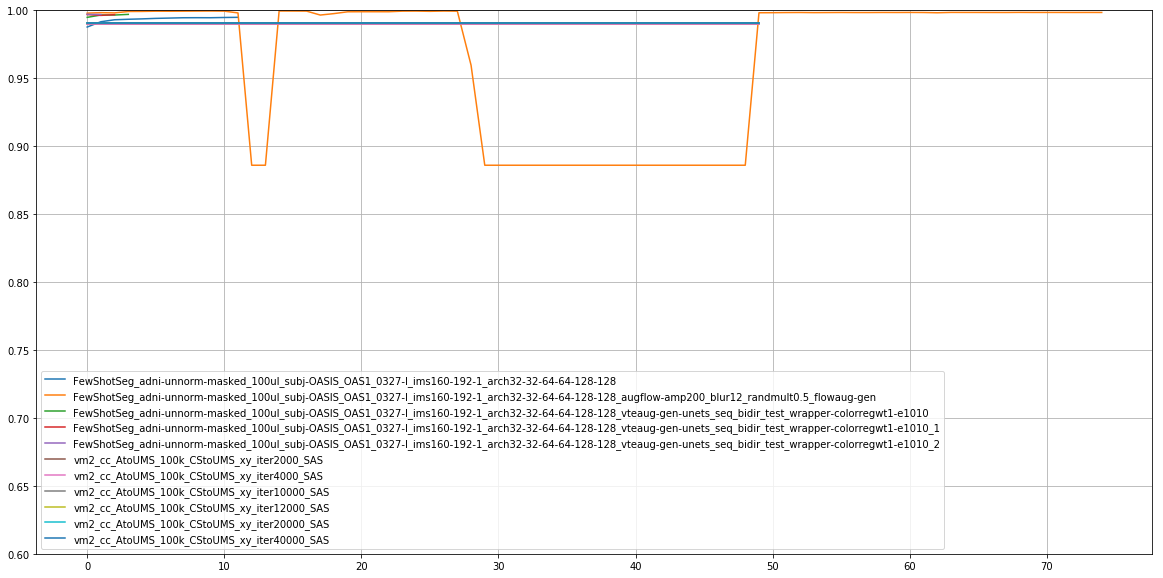

Brain-Stem


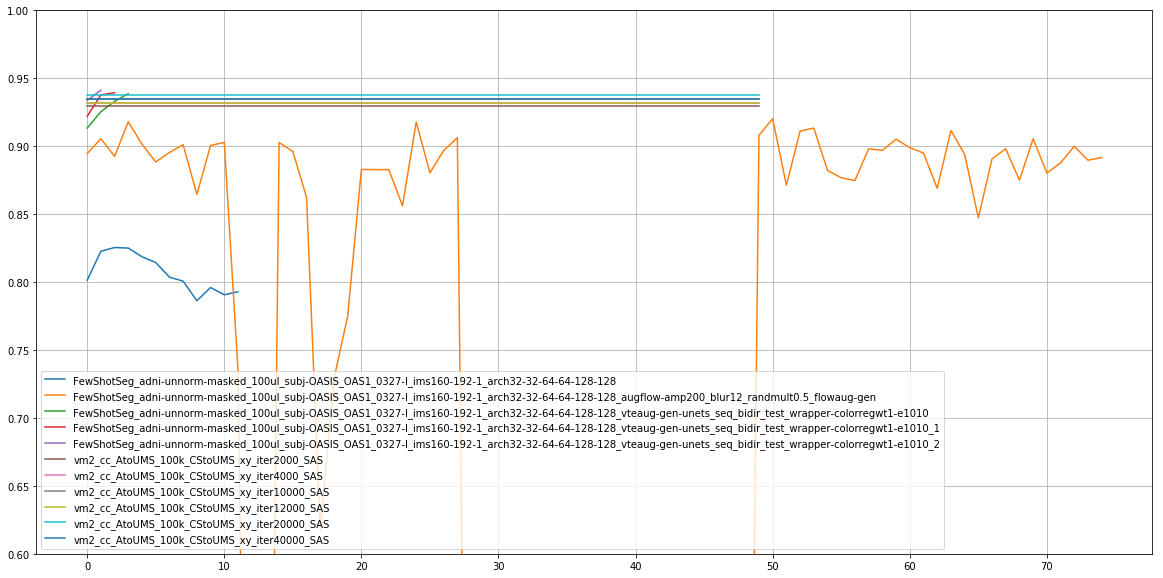

Left-Thalamus


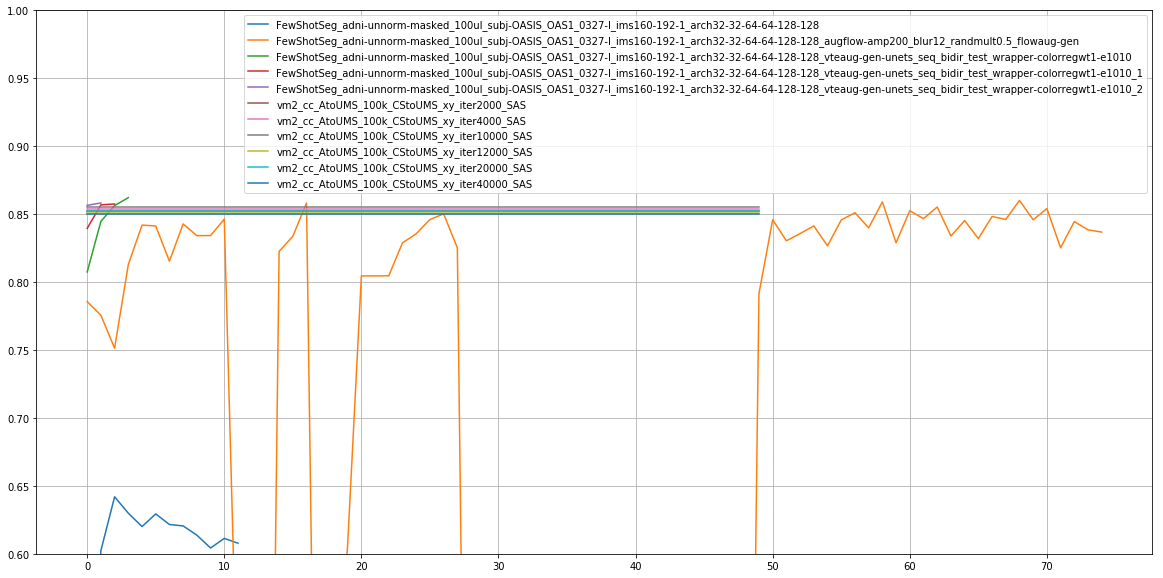

Right-Thalamus


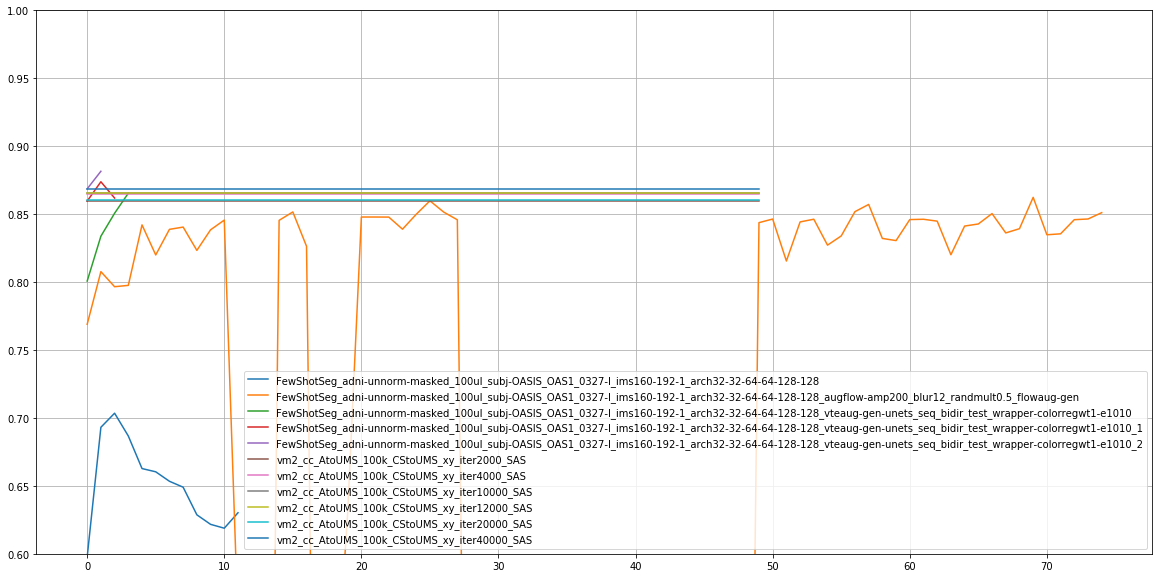

Left-Cerebellum-Cortex


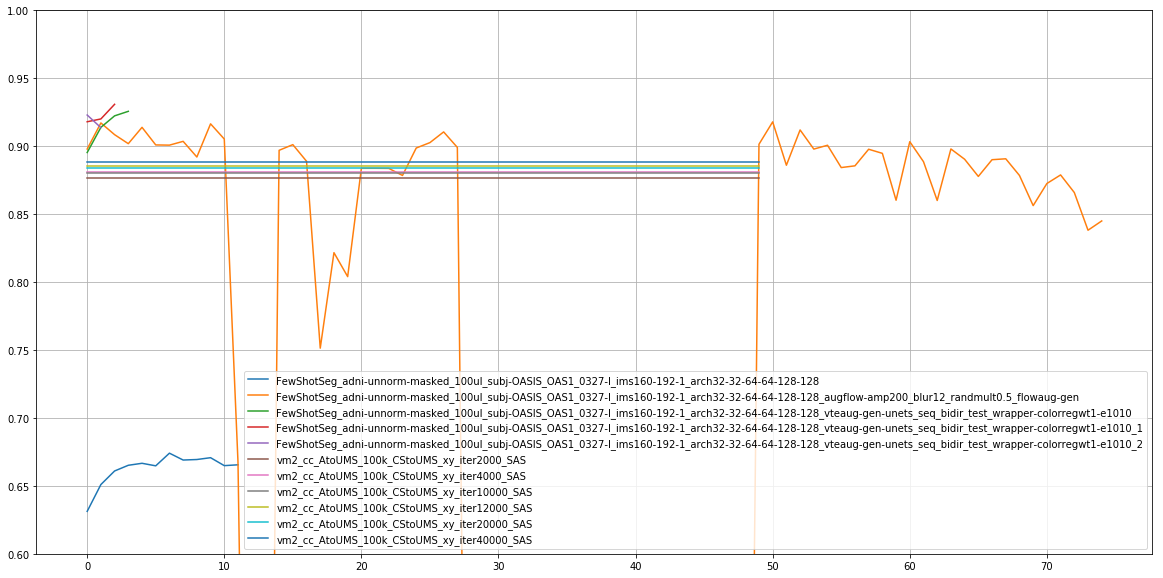

Right-Cerebellum-Cortex


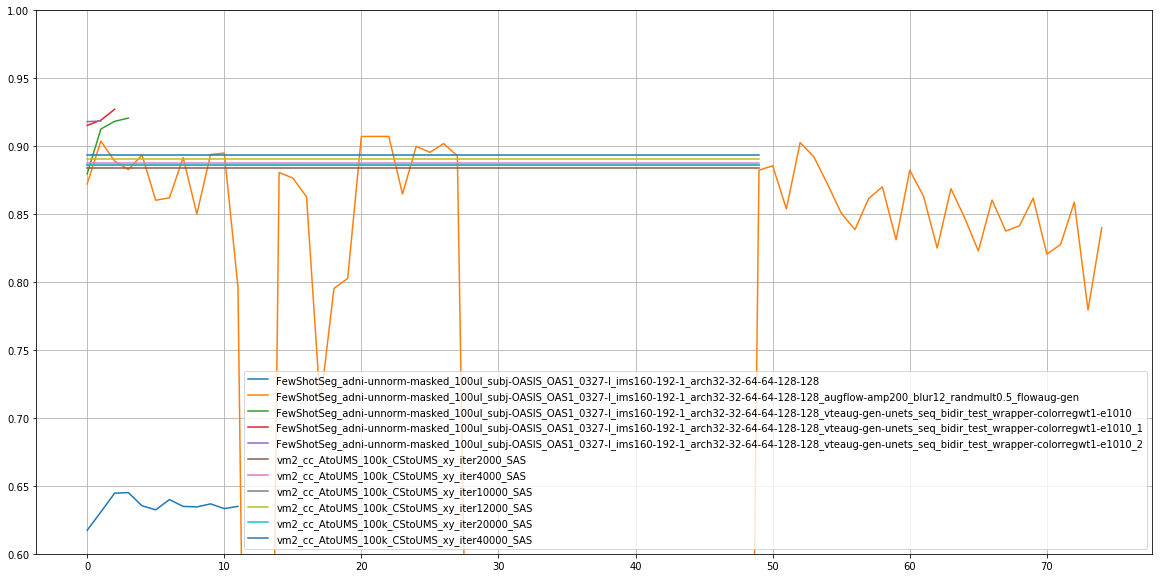

Left-Lateral-Ventricle


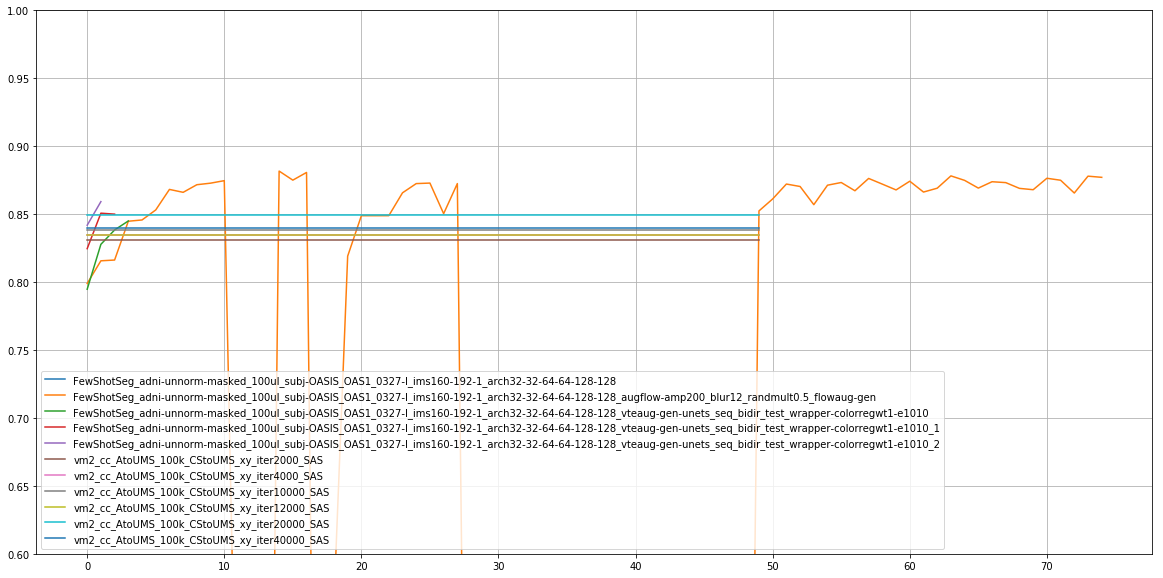

Right-Lateral-Ventricle


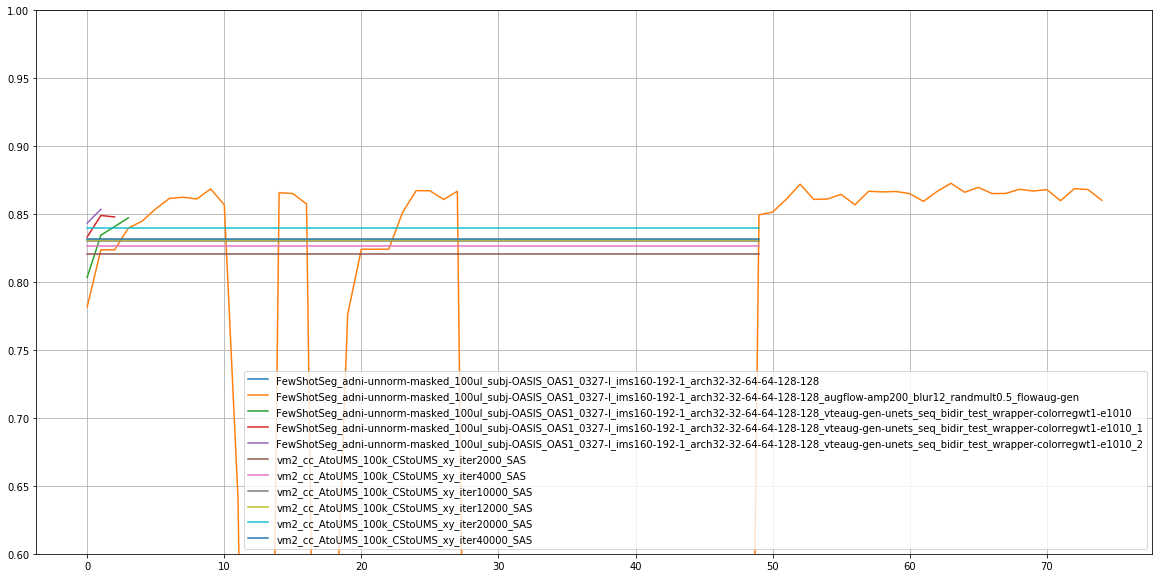

Left-Cerebellum-W. Matter


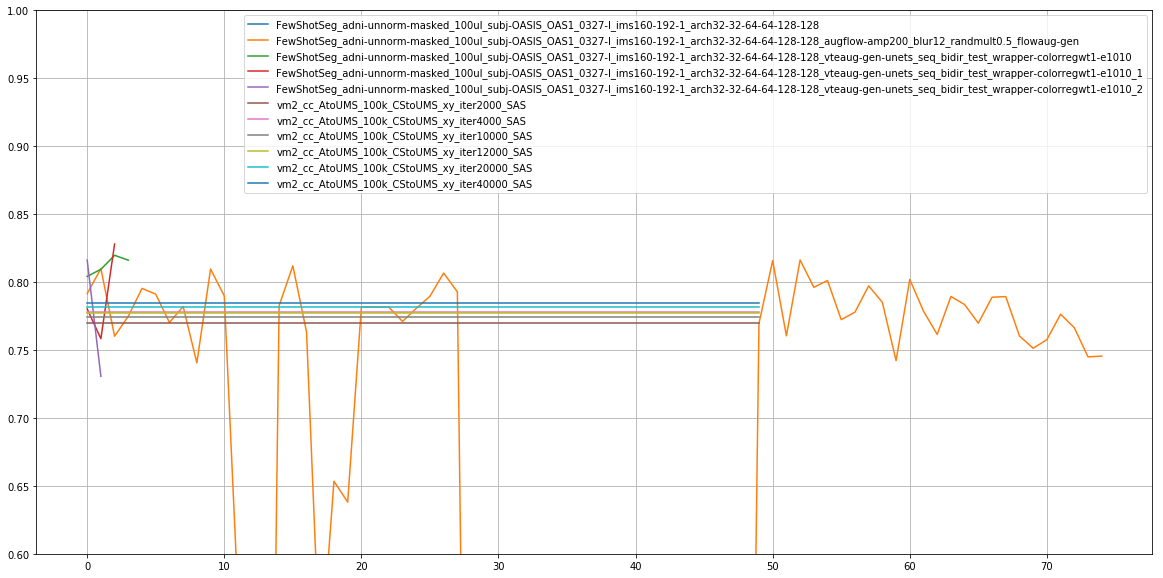

Right-Cerebellum-W. Matter


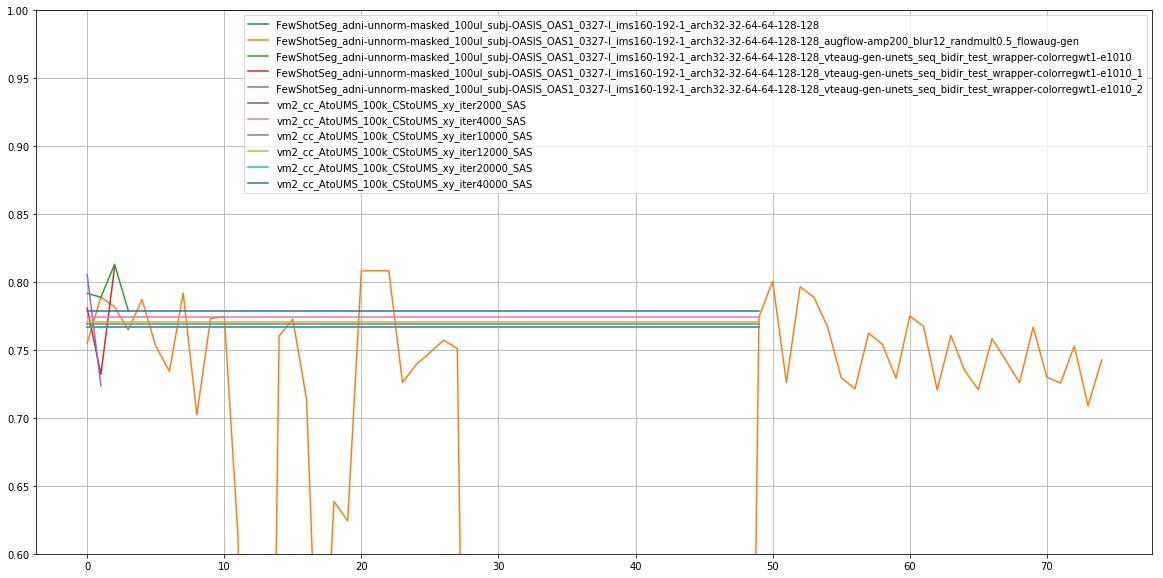

Left-Putamen


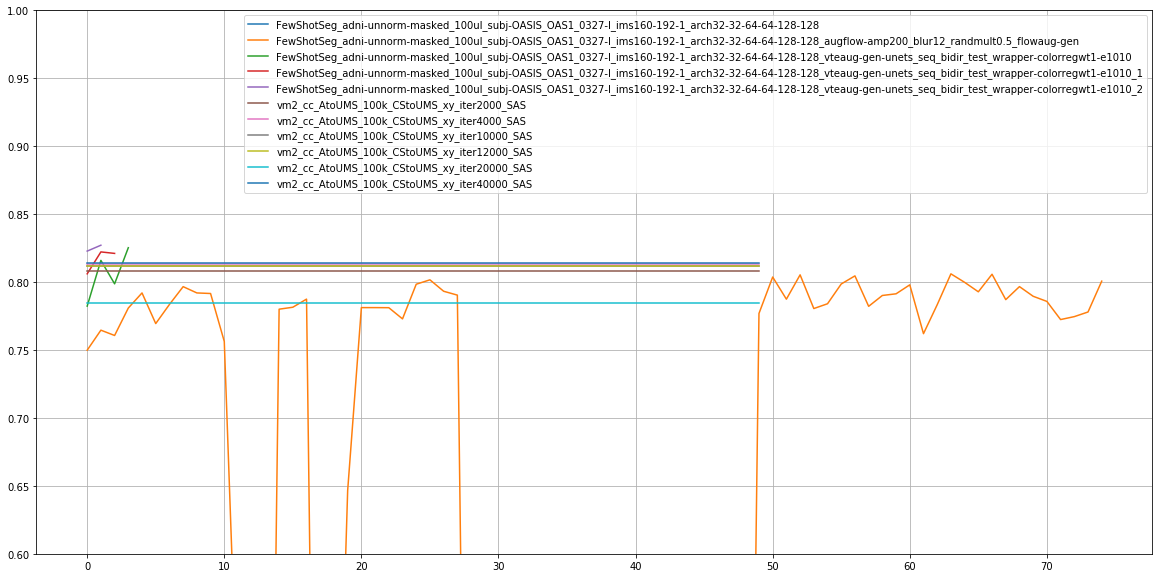

Right-Putamen


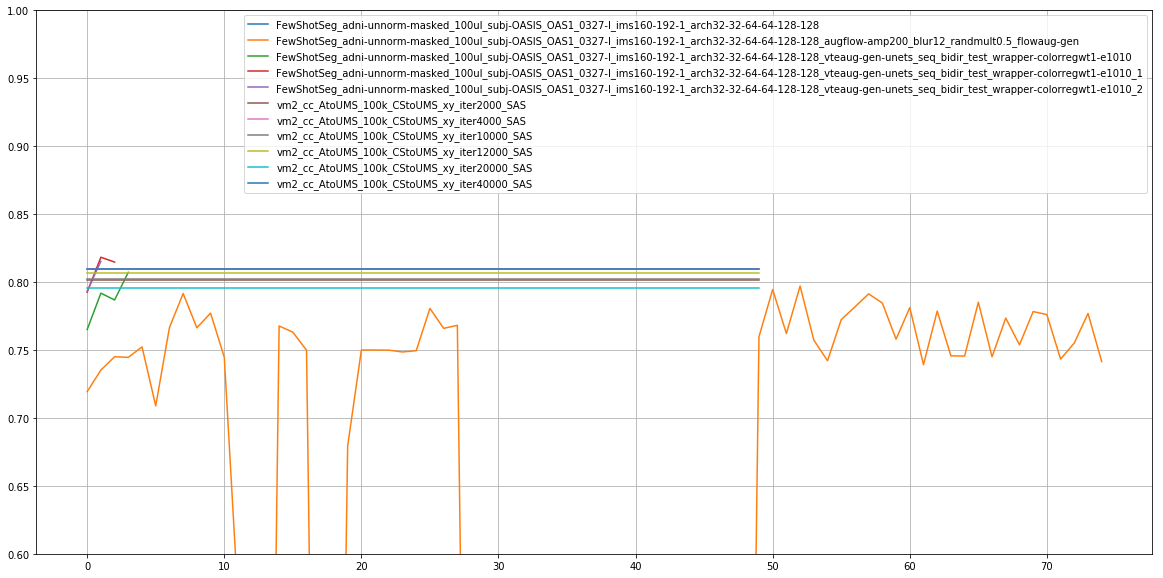

Left-Cerebral-W. Matter


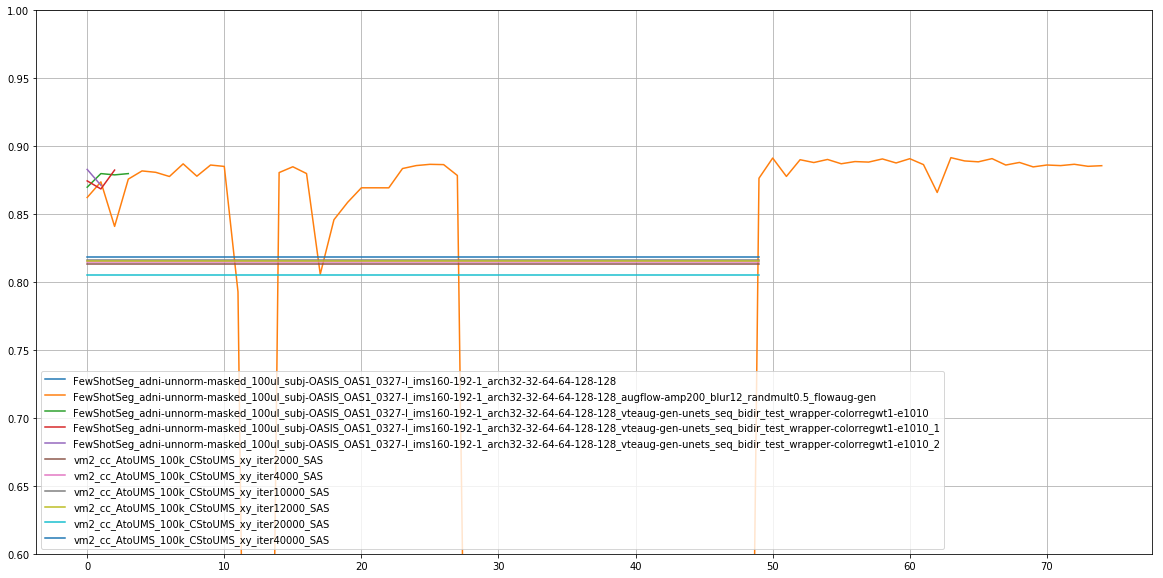

Right-Cerebral-W. Matter


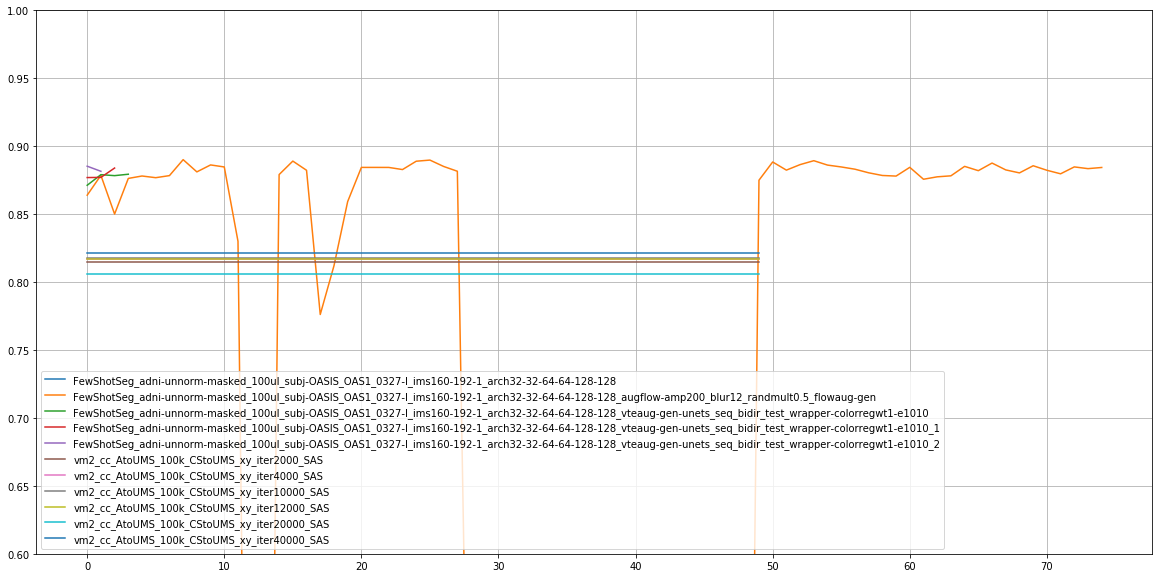

Left-VentralDC


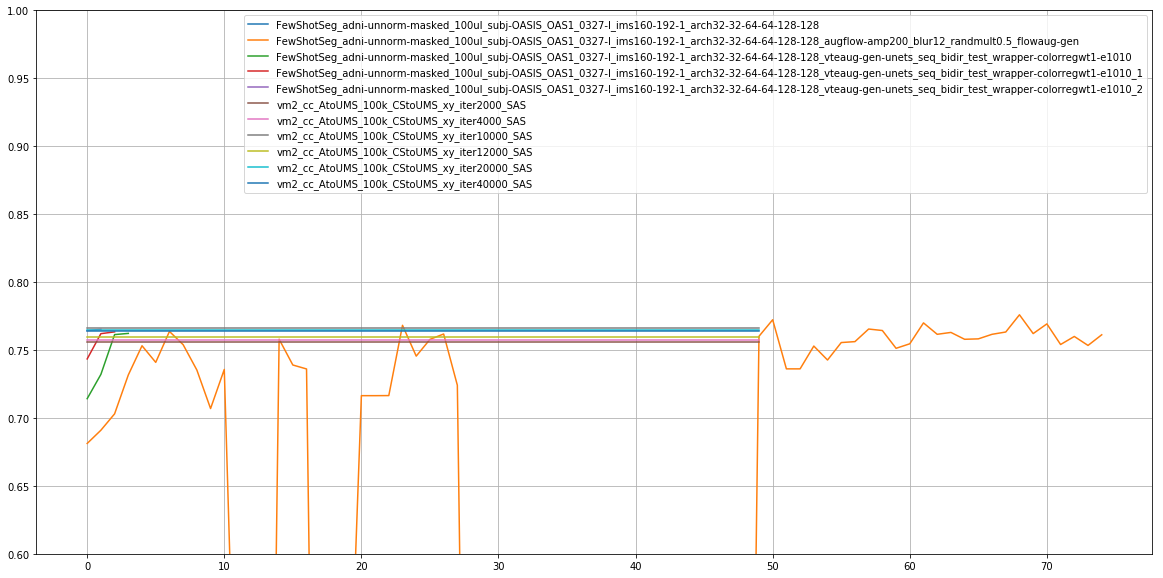

Right-VentralDC


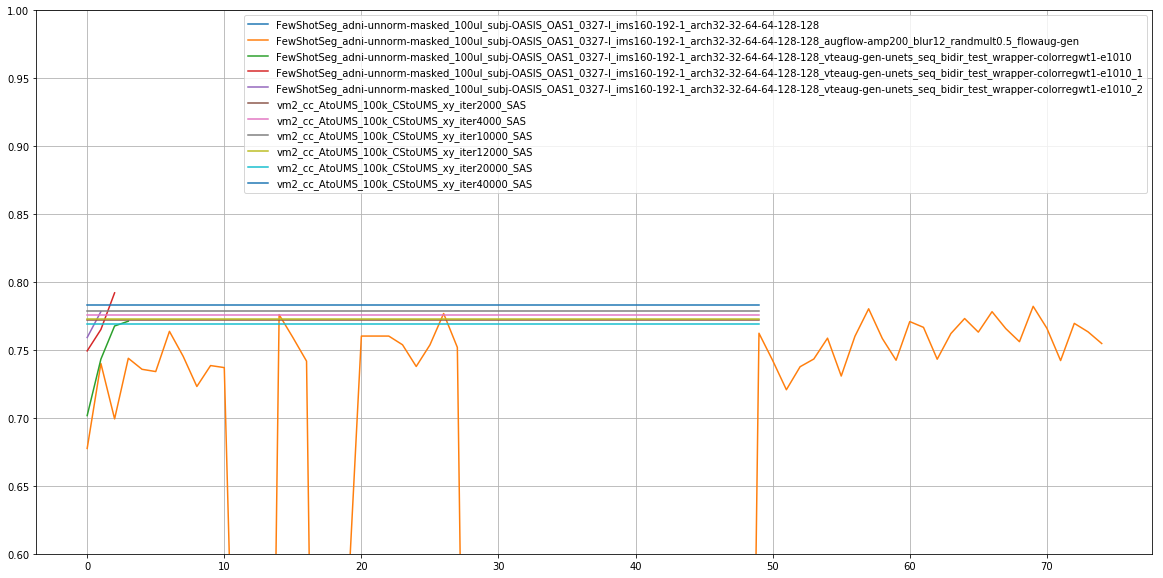

Left-Caudate


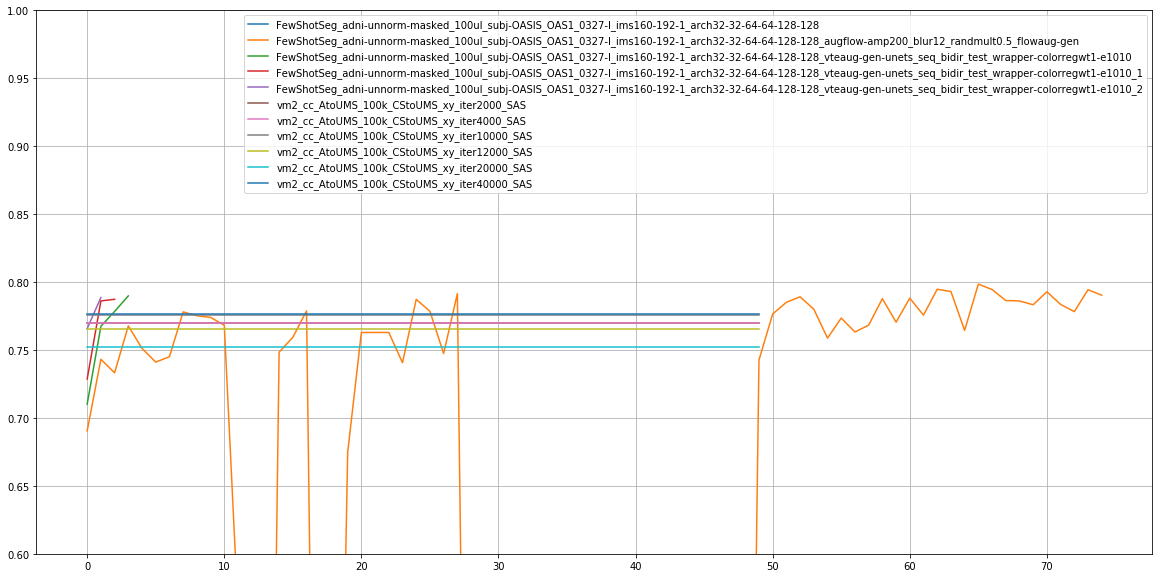

Right-Caudate


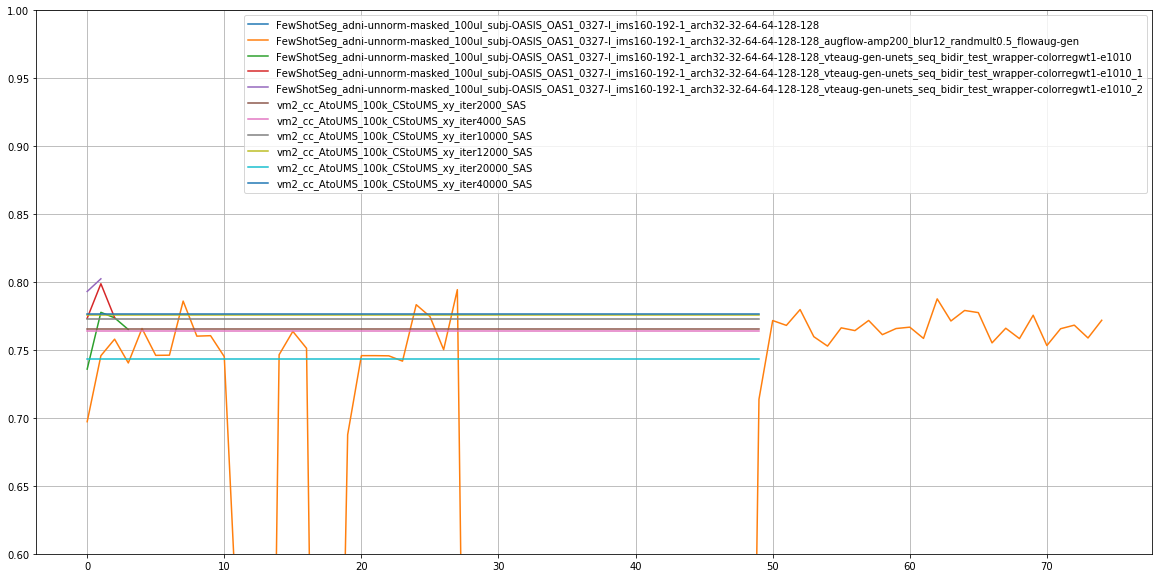

Left-Pallidum


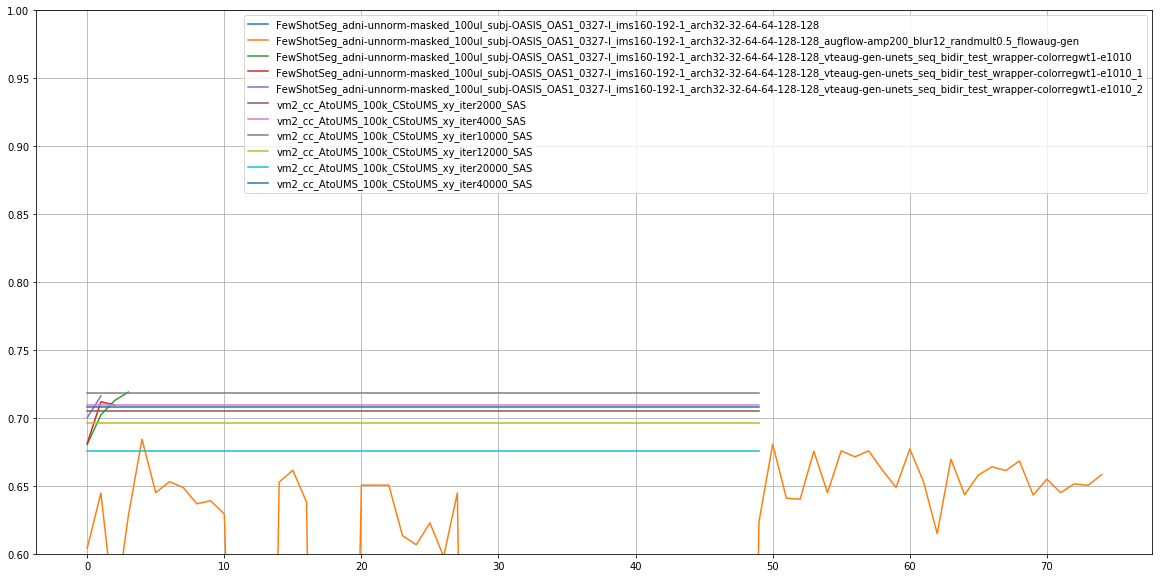

Right-Pallidum


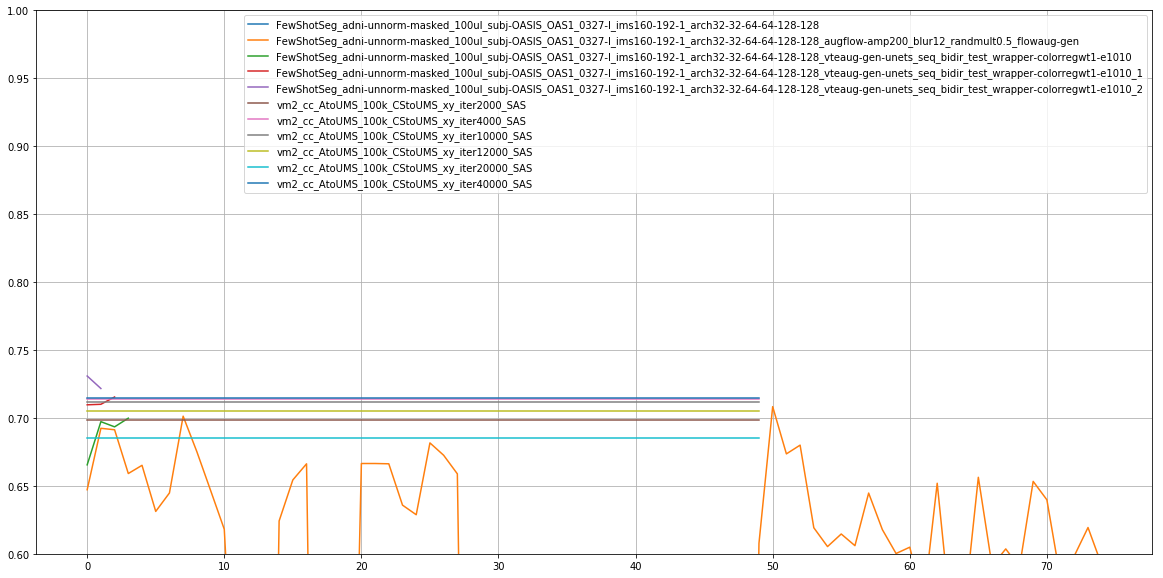

Left-Hippocampus


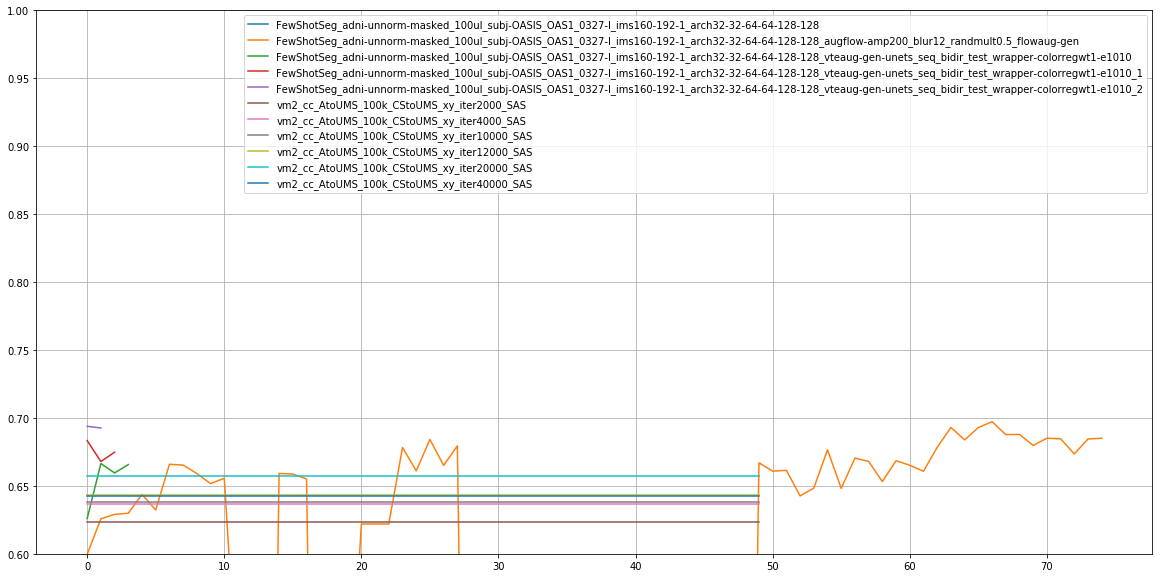

Right-Hippocampus


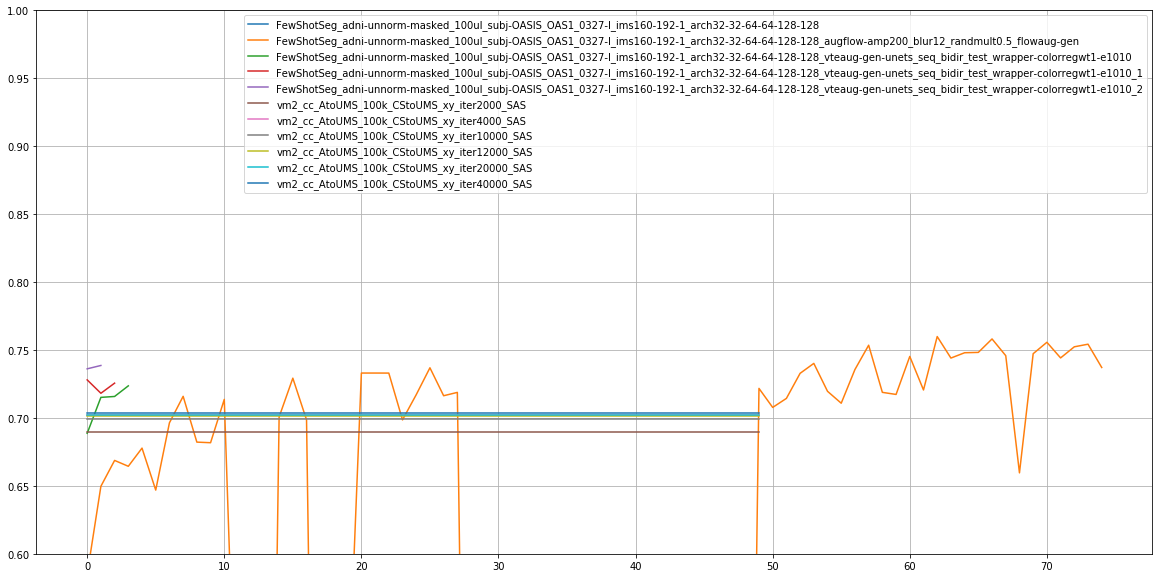

3rd-Ventricle


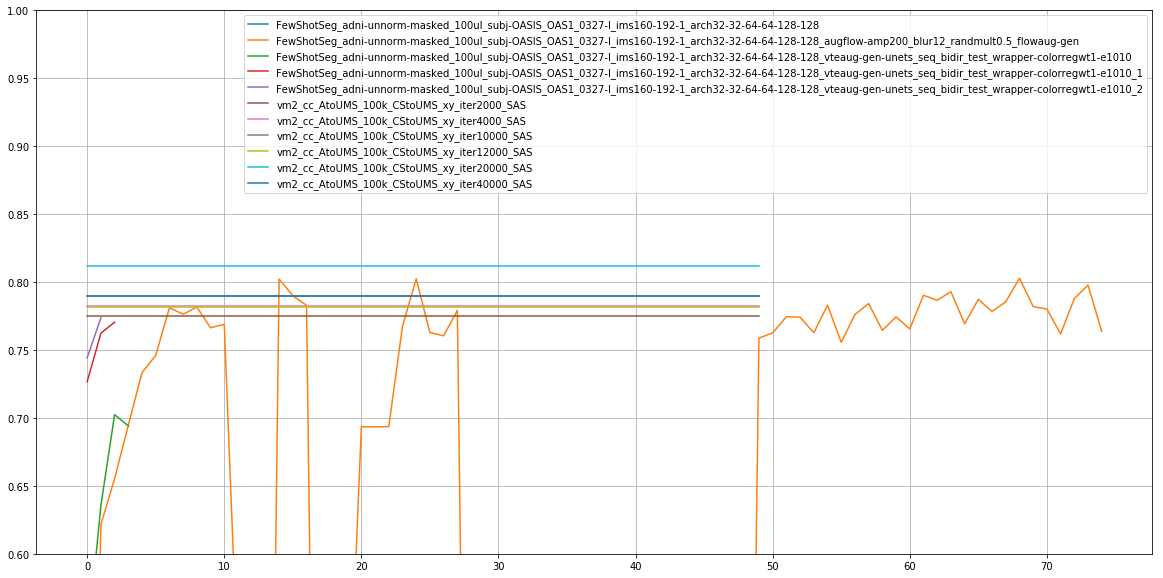

4th-Ventricle


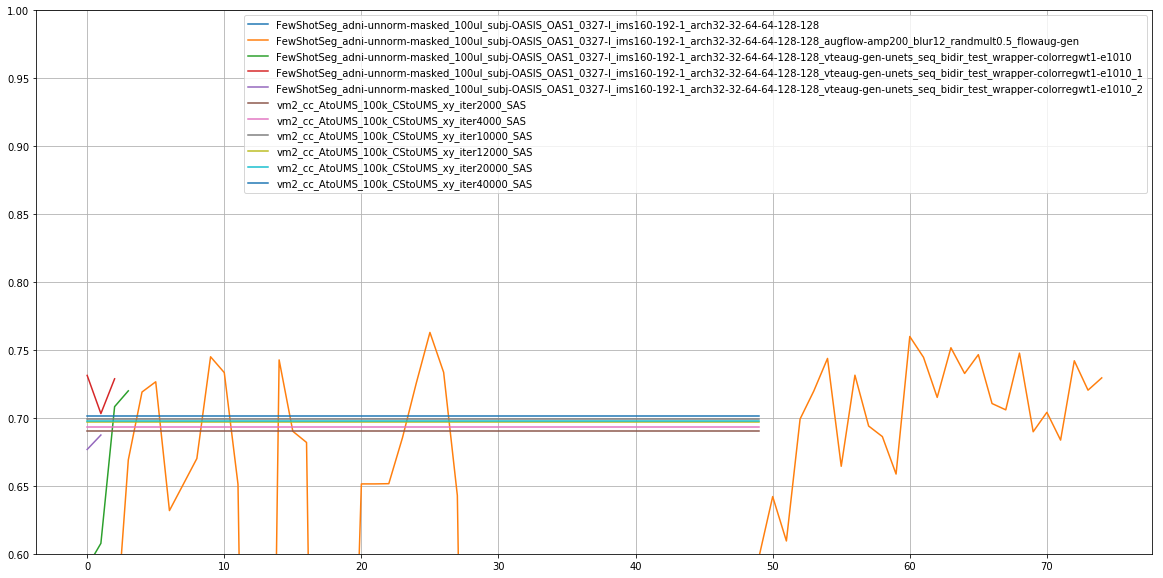

Left-Amygdala


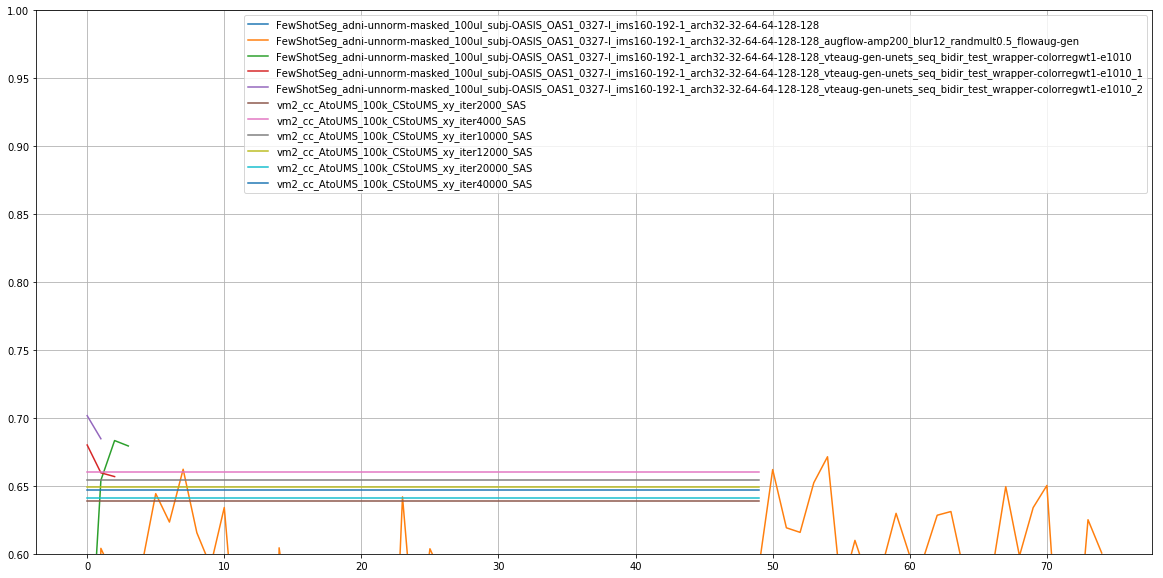

Right-Amygdala


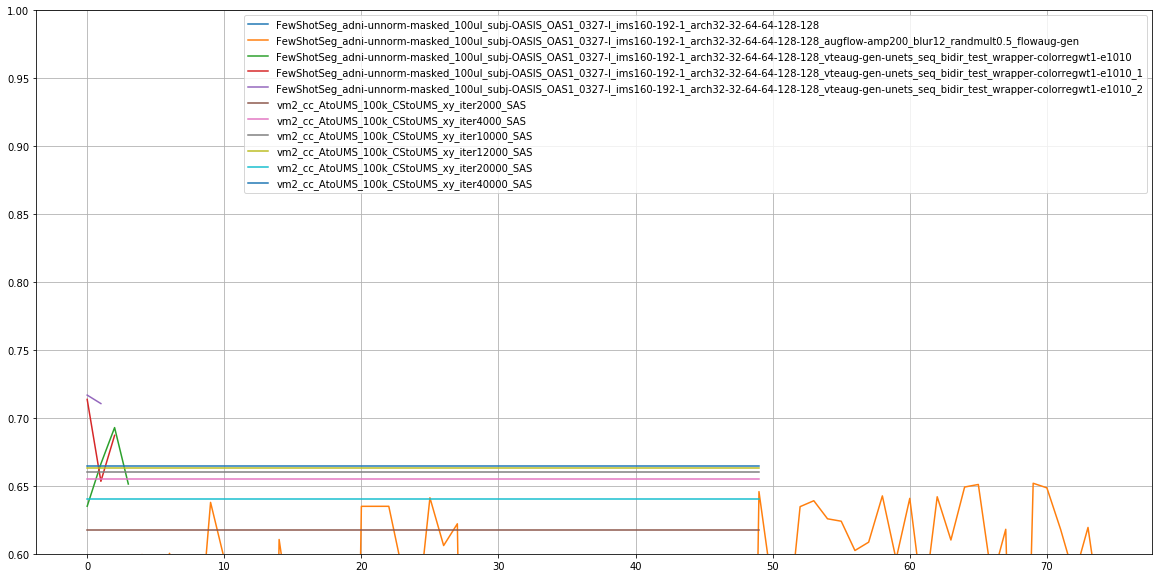

CSF


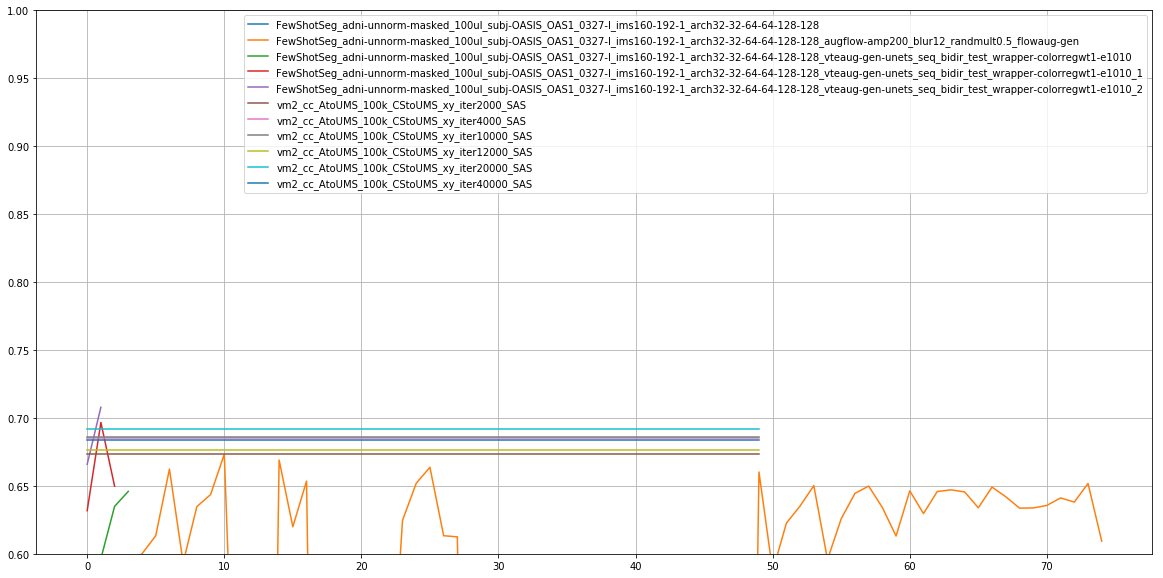

Left-Cerebral-Cortex


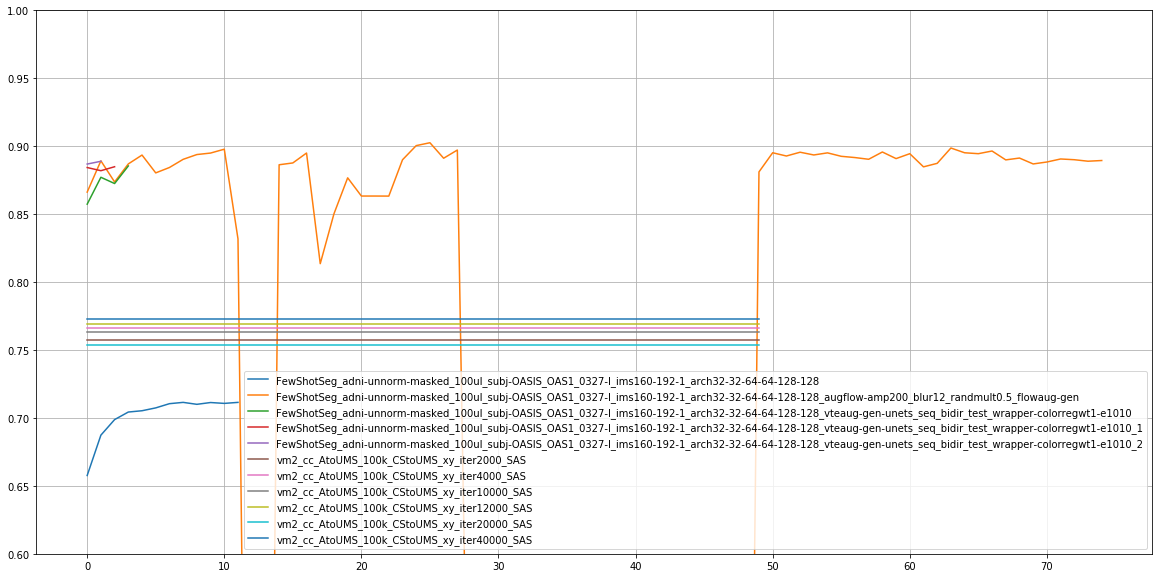

Right-Cerebral-Cortex


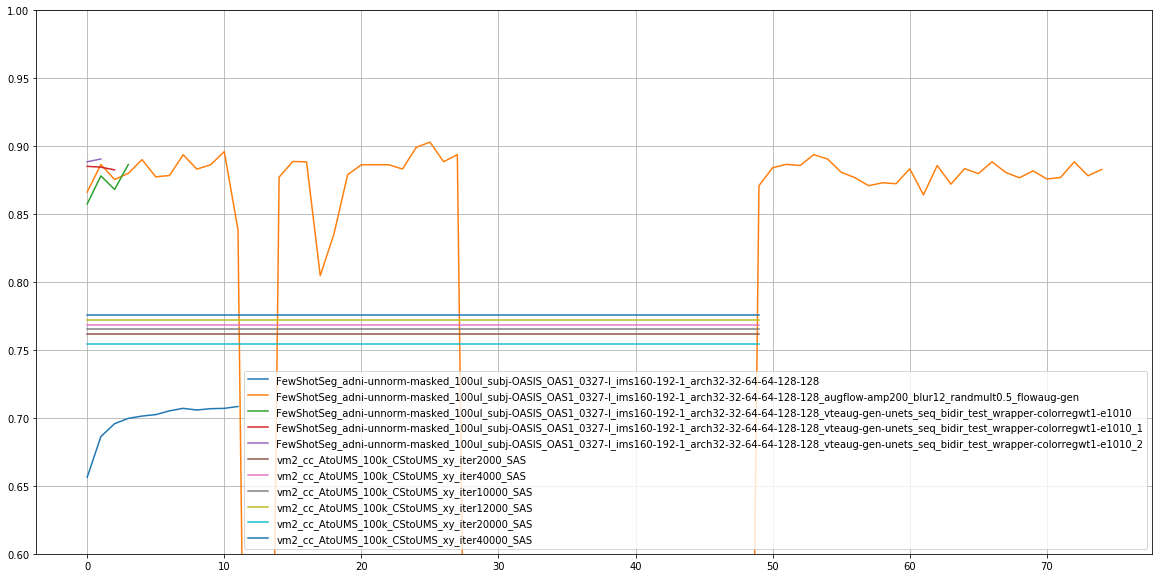

Left-choroid-plexus


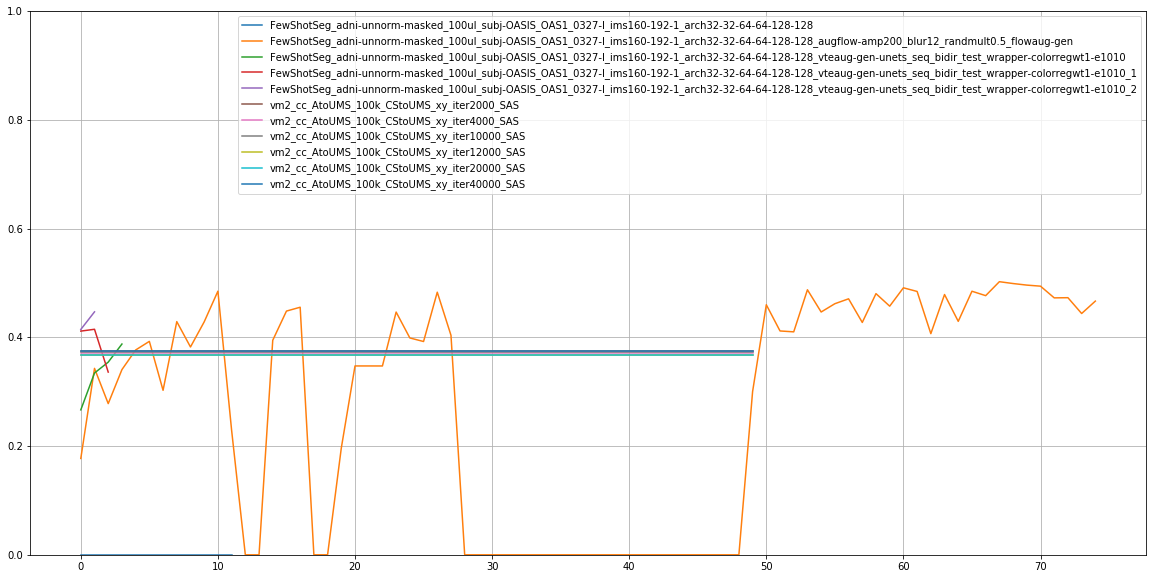

Right-choroid-plexus


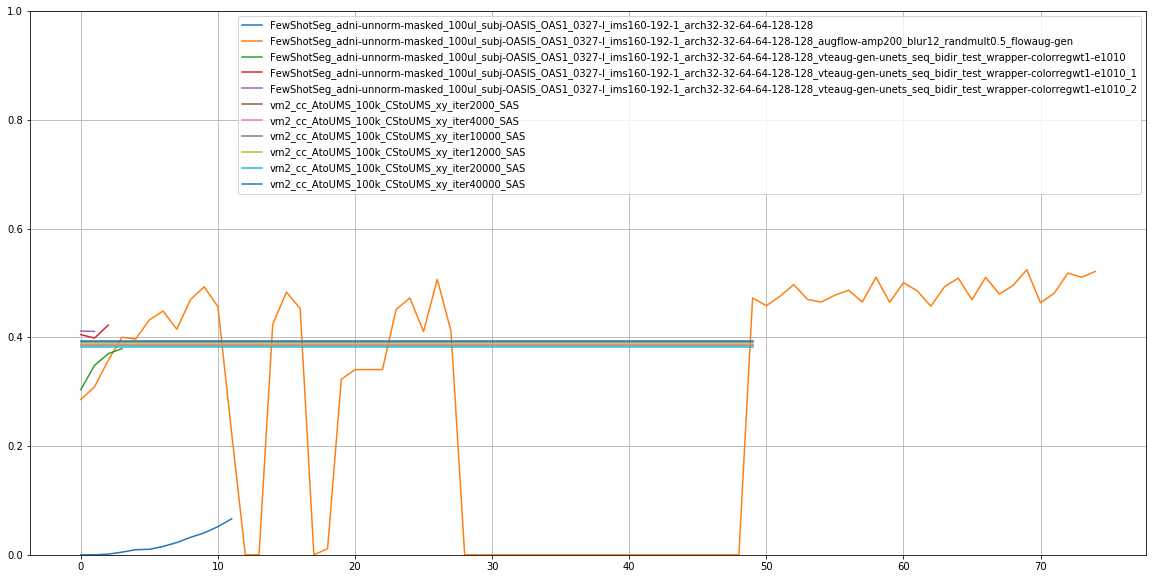

In [21]:
show_exp_idxs = range(len(dice_per_labels))
dice_to_show = [dice_per_labels[si] for si in show_exp_idxs]


for li, l in enumerate(pred_labels):
    print(label_name_mapping[l])

    plt.figure(figsize=(20,10))
    for ei in range(len(dice_to_show)):
        min_t = dice_to_show[ei].shape[0]
        min_t_axis = np.linspace(0, min_t, min_t, endpoint=False)
        plt.plot(min_t_axis, dice_to_show[ei][:min_t, li])
        plt.legend(completed_exps)
        if 'choroid' in label_name_mapping[l].lower():
            plt.ylim([0, 1.0])
        else:
            plt.ylim([0.6, 1.0])
    plt.grid()
    plt.show()

    

In [22]:
our_alg_name = 'FewShotSeg_adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l_ims160-192-1_arch32-32-64-64-128-128_vteaug-gen-unets_seq_bidir_test_wrapper-colorregwt1-e1010'
our_alg_idx = completed_exps.index(our_alg_name)

baseline_alg_name = 'vm2_cc_AtoUMS_100k_CStoUMS_xy_iter40000_SAS'
baseline_alg_idx = completed_exps.index(baseline_alg_name)

our_alg_dice_latest = np.mean(dice_per_labels[our_alg_idx][-10:, :], axis=0)
baseline_alg_dice_latest = np.mean(dice_per_labels[baseline_alg_idx][-10:, :], axis=0)

print(our_alg_dice_latest)
print(baseline_alg_dice_latest)

[0.99613764 0.92752138 0.84257057 0.83757491 0.91422341 0.90774055
 0.82639786 0.83146974 0.81228798 0.79309512 0.80550956 0.78768806
 0.87702713 0.87693017 0.74240739 0.74592521 0.76140835 0.76305905
 0.70360254 0.6889765  0.65439131 0.71077455 0.64095767 0.65656786
 0.62475382 0.66134691 0.55669588 0.87304057 0.87249851 0.33578821
 0.35036083]
[0.99087245 0.93466427 0.85020956 0.8681085  0.8886495  0.89324485
 0.83943535 0.83153029 0.78456885 0.77873559 0.81425133 0.80941098
 0.81876233 0.82149616 0.76414924 0.78306967 0.77613347 0.77638545
 0.70815194 0.71430219 0.64256909 0.70349237 0.7893324  0.70148378
 0.64696314 0.66435242 0.68402583 0.77254181 0.77546778 0.37480669
 0.39358302]


In [23]:
import vte_runner
from dataset_utils import adni_loader
data_params = vte_runner.named_vte_data_params['adni-3d-100-unnorm-masked-csts2']
data_params['load_vols'] = False
ds = adni_loader.ADNIDataset(data_params)
ds.load_dataset(True)

label_sizes = []
for l in pred_labels:
    label_sizes.append(np.sum(ds.Y_atlas==l))

Using TensorFlow backend.
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Loading adni dataset adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l
Params: {'dataset_name': 'adni', 'source_name': 'atl', 'target_name': 'subjs', 'unnormalized': True, 'masked': True, 'n_shot': 1, 'use_atlas_as_source': False, 'use_subject': 'OASIS_OAS1_0327_MR1_mri_talairach_orig', 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 100, 'n_validation': 50, 'load_vols': False, 'aug_in_gen': True, 'n_vte_aug': None, 'n_flow_aug': None, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'warp_labels': True, 'n_dims': 3, 'orig_img_shape': (160, 192, 224, 1), 'scale': 1.0, 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_S_1326_base_

In [24]:
print(label_sizes)

[5221692, 28516, 9085, 8807, 73790, 71348, 14061, 12262, 17282, 17459, 6008, 5899, 340259, 338885, 5957, 5749, 4009, 4134, 2054, 2085, 4862, 4971, 1542, 2559, 1741, 1838, 1322, 336479, 334947, 682, 996]


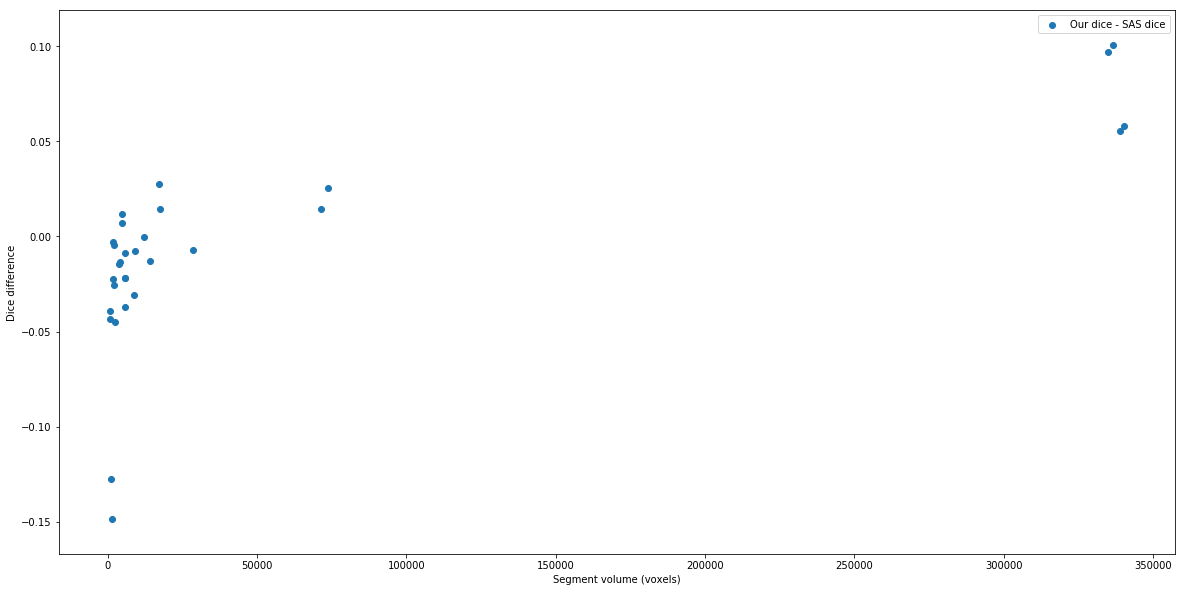

In [25]:
plt.figure(figsize=(20,10))

sorted_label_sizes, sort_label_idxs = zip(*sorted(zip(label_sizes, range(len(label_sizes)))))

our_alg_dice_sorted = [our_alg_dice_latest[si] for si in sort_label_idxs]
baseline_alg_dice_sorted = [baseline_alg_dice_latest[si] for si in sort_label_idxs]
dice_diff = np.asarray(our_alg_dice_sorted) - np.asarray(baseline_alg_dice_sorted)
                       
plt.scatter(sorted_label_sizes[:-1], dice_diff[:-1])
plt.legend(['Our dice - SAS dice'])
plt.xlabel('Segment volume (voxels)')
plt.ylabel('Dice difference')
plt.show()

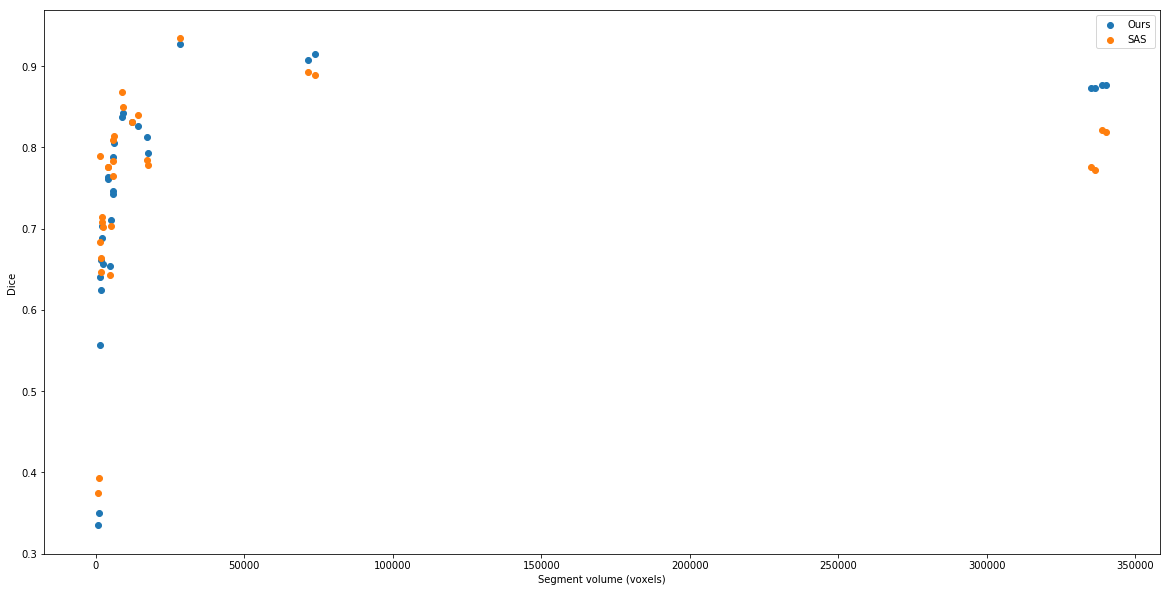

In [26]:
plt.figure(figsize=(20,10))

sorted_label_sizes, sort_label_idxs = zip(*sorted(zip(label_sizes, range(len(label_sizes)))))

our_alg_dice_sorted = [our_alg_dice_latest[si] for si in sort_label_idxs]
baseline_alg_dice_sorted = [baseline_alg_dice_latest[si] for si in sort_label_idxs]
dice_diff = np.asarray(our_alg_dice_sorted) - np.asarray(baseline_alg_dice_sorted)
                       
plt.scatter(sorted_label_sizes[:-1], our_alg_dice_sorted[:-1])
plt.scatter(sorted_label_sizes[:-1], baseline_alg_dice_sorted[:-1])
plt.legend(['Ours', 'SAS'])
plt.xlabel('Segment volume (voxels)')
plt.ylabel('Dice')
plt.show()